#**Discovering Key-Drivers for Boosting Thailand's Digital Competitiveness Index Using an NLP Approach**
---
Pichaya Charoonpongsakdi (Anik) <br>
GA-TDA DSI Capstone Project

# **Part 0: Problem Statement**
---

#**Part 1: Data Preparation**
---


##1.0 Install and Import Libraries

In [1]:
# COLAB
# Install pythainlp library
# !pip install pythainlp

In [2]:
# Import Basic Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Sklearn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import NLP Libraries
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from pythainlp.tokenize import sent_tokenize, word_tokenize
from pythainlp.corpus import thai_stopwords
import re
from tqdm import tqdm 
import pyLDAvis
import pyLDAvis.gensim_models


# Set default Thai font
mpl.font_manager.fontManager.addfont('./THSarabunNew/THSarabunNew.ttf')
mpl.rc('font', family='TH Sarabun New', size=20)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# COLAB
# Other Libraries
# from google.colab import files
# from google.colab import drive

/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# COLAB
# Download TH Sarabun (Thai font)
# !gdown 1rZSpiIh6fTeaDPOCKvamgtlR3qN2UQEl

# Set TH Sarabun as default Thai font
# mpl.font_manager.fontManager.addfont('/content/THSarabunNew.ttf')
# mpl.rc('font', family='TH Sarabun New', size=20)

## 1.1 Load Datasets

In [4]:
# COLAB
# Download datasets from Google Drive
# !gdown 1BQtzBne72ML1OoJG46IbYQ_v9pUrOq1K

# Import datasets
# bkkbiz = pd.read_json('/content/bkkbiz_update.json')

In [5]:
# Import datasets
bkkbiz = pd.read_json('../datasets/bkkbiz_update.json')
matichon = pd.read_json('../datasets/matichon.json')

In [6]:
# Check head
bkkbiz.head()

,ID,date,category,title,description,article,url
0,620001,2014-11-27 08:01:00,ต่างประเทศ,น้ำมันดิบปิดร่วง-คาดโอเปคไม่ลดกำลังผลิต,น้ำมันดิบปิดร่วงแตะระดับต่ำสุดในรอบ 4 ปี-คาดโอ...,สัญญาน้ำมันดิบตลาดล่วงหน้าสหรัฐ ปิดตลาดปรับตัว...,https://www.bangkokbiznews.com/news/detail/620001
1,620002,2014-11-27 08:20:00,ต่างประเทศ,ทองคำปิดร่วงหลังสหรัฐเผยข้อมูลเศรษฐกิจ,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,https://www.bangkokbiznews.com/news/detail/620002
2,620009,2014-11-27 09:34:00,การเงิน-การลงทุน,"ทองแท่งขายออก18,600บ.ไม่เปลี่ยนแปลง","ราคาทองคำวันนี้ทองแท่งขายออกบาทละ 18,600 บาท ท...",สมาคมค้าทองคำรายงานราคาทอง 96.5% ประจำวันที่ 2...,https://www.bangkokbiznews.com/news/detail/620009
3,620010,2014-11-27 09:36:00,การเงิน-การลงทุน,เงินบาทเปิด32.75/77คาดแกว่งแคบ,ค่าเงินบาทเปิดที่ 32.75/77 บาท/ดอลลาร์ คาดแกว่...,นักบริหารเงินจากธนาคารพาณิชย์ เปิดเผยว่า เงินบ...,https://www.bangkokbiznews.com/news/detail/620010
4,620011,2014-11-27 09:48:00,การเงิน-การลงทุน,คาดหุ้นเช้าแกว่งไซด์เวย์,โบรกฯ คาดหุ้นเช้านี้แกว่งไซด์เวย์ช่วงไร้ปัจจัย...,นายอภิชาติ ผู้บรรเจิดกุล ผู้อำนวยการสายงานวิเค...,https://www.bangkokbiznews.com/news/detail/620011


In [7]:
# Check head
matichon.head()

,headline,article,date,category,url,id
0,ผบ.ทร.งง! ขอ'เรือดำน้ำ'ถูกโวย แต่อย่างอื่นนิ่ง...,วันที่ 7 มีนาคม พล.ร.อ.ไกรสร จันทร์สุวานิชย์ ผ...,2015-07-08 06:49:57,politics,https://www.matichon.co.th/politics/news_38,38
1,ปล่อยวัชพืช-พร่องน้ำ ภาพรวมน้ำอ่างยังไม่ถึง50เ...,17 ส.ค. – นายพัฒนะ พลศรี หัวหน้าฝ่ายส่งน้ำและบ...,2015-08-17 10:51:32,local,https://www.matichon.co.th/local/news_68,68
2,นายกฯโอดน้องผมทำอะไรผิด ยันผบ.ทบ.ต้องโตด้วยตัว...,พลเอกประยุทธ์ จันทร์โอชา นายกรัฐมนตรี และหัวหน...,2015-08-11 09:48:08,politics,https://www.matichon.co.th/politics/news_75,75
3,อนาคตทางการเมือง ของกปปส.และสุเทพ,คำแถลงของคุณสุเทพ เทือกสุบรรณ หลังลาสิกขาดูเหม...,2015-08-13 11:29:16,columnists,https://www.matichon.co.th/columnists/news_79,79
4,โสมแดงกร้าว! ขู่ตอบโต้รุนแรง หากสหรัฐไม่ยุติซ้...,(16 ส.ค.58) สำนักข่าวซีเอ็นเอ็นรายงานว่า ทางกา...,2015-08-16 10:26:54,foreign,https://www.matichon.co.th/foreign/news_86,86


## 1.2 Data Cleaning


In [8]:
# Check shape
bkkbiz.shape

(361228, 7)

In [9]:
# Convert column heads to lower case
bkkbiz.columns.str.lower()

Index(['id', 'date', 'category', 'title', 'description', 'article', 'url'], dtype='object')

In [10]:
# Check nulls
bkkbiz.isnull().sum()

ID             0
date           0
category       0
title          0
description    0
article        0
url            0
dtype: int64

In [11]:
# Check dtypes
bkkbiz.dtypes

ID                      int64
date           datetime64[ns]
category               object
title                  object
description            object
article                object
url                    object
dtype: object

In [12]:
# Check shape
matichon.shape

(432901, 6)

In [13]:
# Convert column heads to lower case
matichon.columns.str.lower()

Index(['headline', 'article', 'date', 'category', 'url', 'id'], dtype='object')

In [14]:
matichon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432901 entries, 0 to 432900
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   headline  432901 non-null  object
 1   article   432901 non-null  object
 2   date      432901 non-null  object
 3   category  432901 non-null  object
 4   url       432901 non-null  object
 5   id        432901 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 19.8+ MB


In [15]:
# Convert date to datetime
matichon['date'] = pd.to_datetime(matichon['date'], utc=True)

In [16]:
# Recheck dtypes
matichon.dtypes

headline                 object
article                  object
date        datetime64[ns, UTC]
category                 object
url                      object
id                        int64
dtype: object

In [17]:
# Rename headline to article
matichon.rename(columns={'headline':'title'}, inplace=True)

In [18]:
# Recheck
matichon.head()

,title,article,date,category,url,id
0,ผบ.ทร.งง! ขอ'เรือดำน้ำ'ถูกโวย แต่อย่างอื่นนิ่ง...,วันที่ 7 มีนาคม พล.ร.อ.ไกรสร จันทร์สุวานิชย์ ผ...,2015-07-08 06:49:57+00:00,politics,https://www.matichon.co.th/politics/news_38,38
1,ปล่อยวัชพืช-พร่องน้ำ ภาพรวมน้ำอ่างยังไม่ถึง50เ...,17 ส.ค. – นายพัฒนะ พลศรี หัวหน้าฝ่ายส่งน้ำและบ...,2015-08-17 10:51:32+00:00,local,https://www.matichon.co.th/local/news_68,68
2,นายกฯโอดน้องผมทำอะไรผิด ยันผบ.ทบ.ต้องโตด้วยตัว...,พลเอกประยุทธ์ จันทร์โอชา นายกรัฐมนตรี และหัวหน...,2015-08-11 09:48:08+00:00,politics,https://www.matichon.co.th/politics/news_75,75
3,อนาคตทางการเมือง ของกปปส.และสุเทพ,คำแถลงของคุณสุเทพ เทือกสุบรรณ หลังลาสิกขาดูเหม...,2015-08-13 11:29:16+00:00,columnists,https://www.matichon.co.th/columnists/news_79,79
4,โสมแดงกร้าว! ขู่ตอบโต้รุนแรง หากสหรัฐไม่ยุติซ้...,(16 ส.ค.58) สำนักข่าวซีเอ็นเอ็นรายงานว่า ทางกา...,2015-08-16 10:26:54+00:00,foreign,https://www.matichon.co.th/foreign/news_86,86


## 1.3 EDA

### 1.3.1 Bangkok Business (กรุงเทพธุรกิจ)

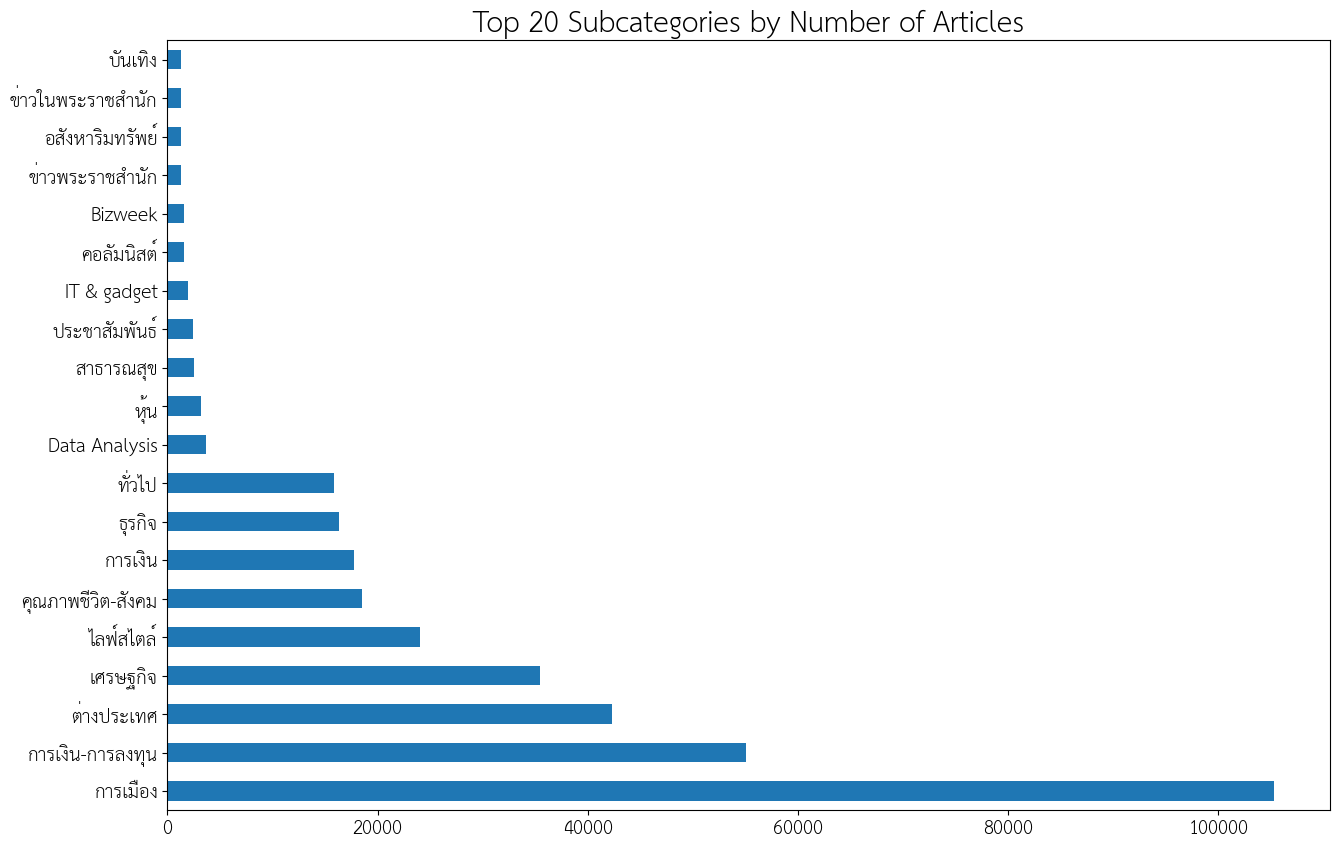

In [19]:
# Top 20 subcategories by number of articles
plt.figure(figsize=(15,10))
plt.title('Top 20 Subcategories by Number of Articles', size=30)
bkkbiz['category'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh');

In [20]:
# Time released
bkkbiz['date'].dt.year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [21]:
# Number of Article by Year
bkkbiz.groupby(bkkbiz['date'].dt.year)['title'].count()

date
2014     4646
2015    51297
2016    25825
2017    51332
2018    34992
2019    36653
2020    53321
2021    63939
2022    39223
Name: title, dtype: int64

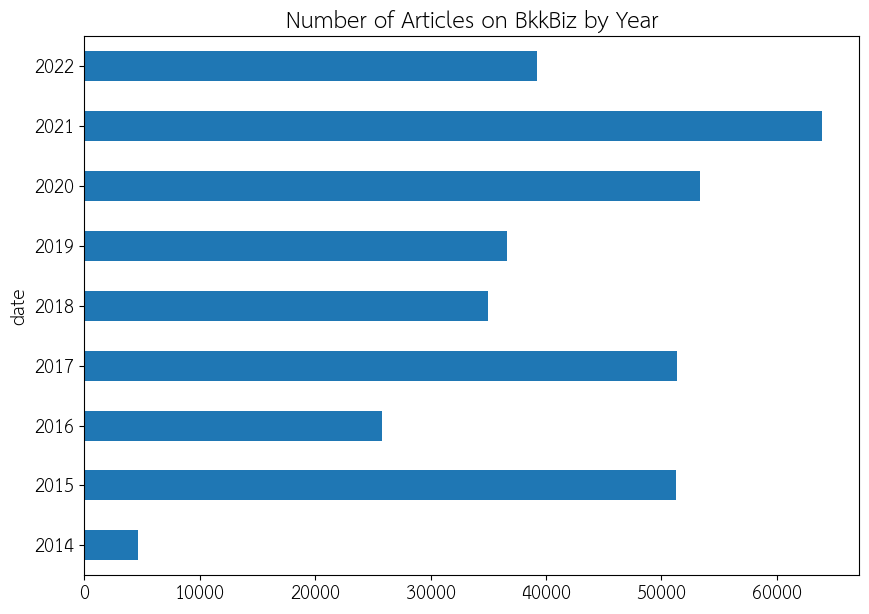

In [22]:
# Number of Article by Year
plt.figure(figsize=(10,7))
plt.title('Number of Articles on BkkBiz by Year')
bkkbiz.groupby(bkkbiz['date'].dt.year)['title'].count().plot(kind='barh');

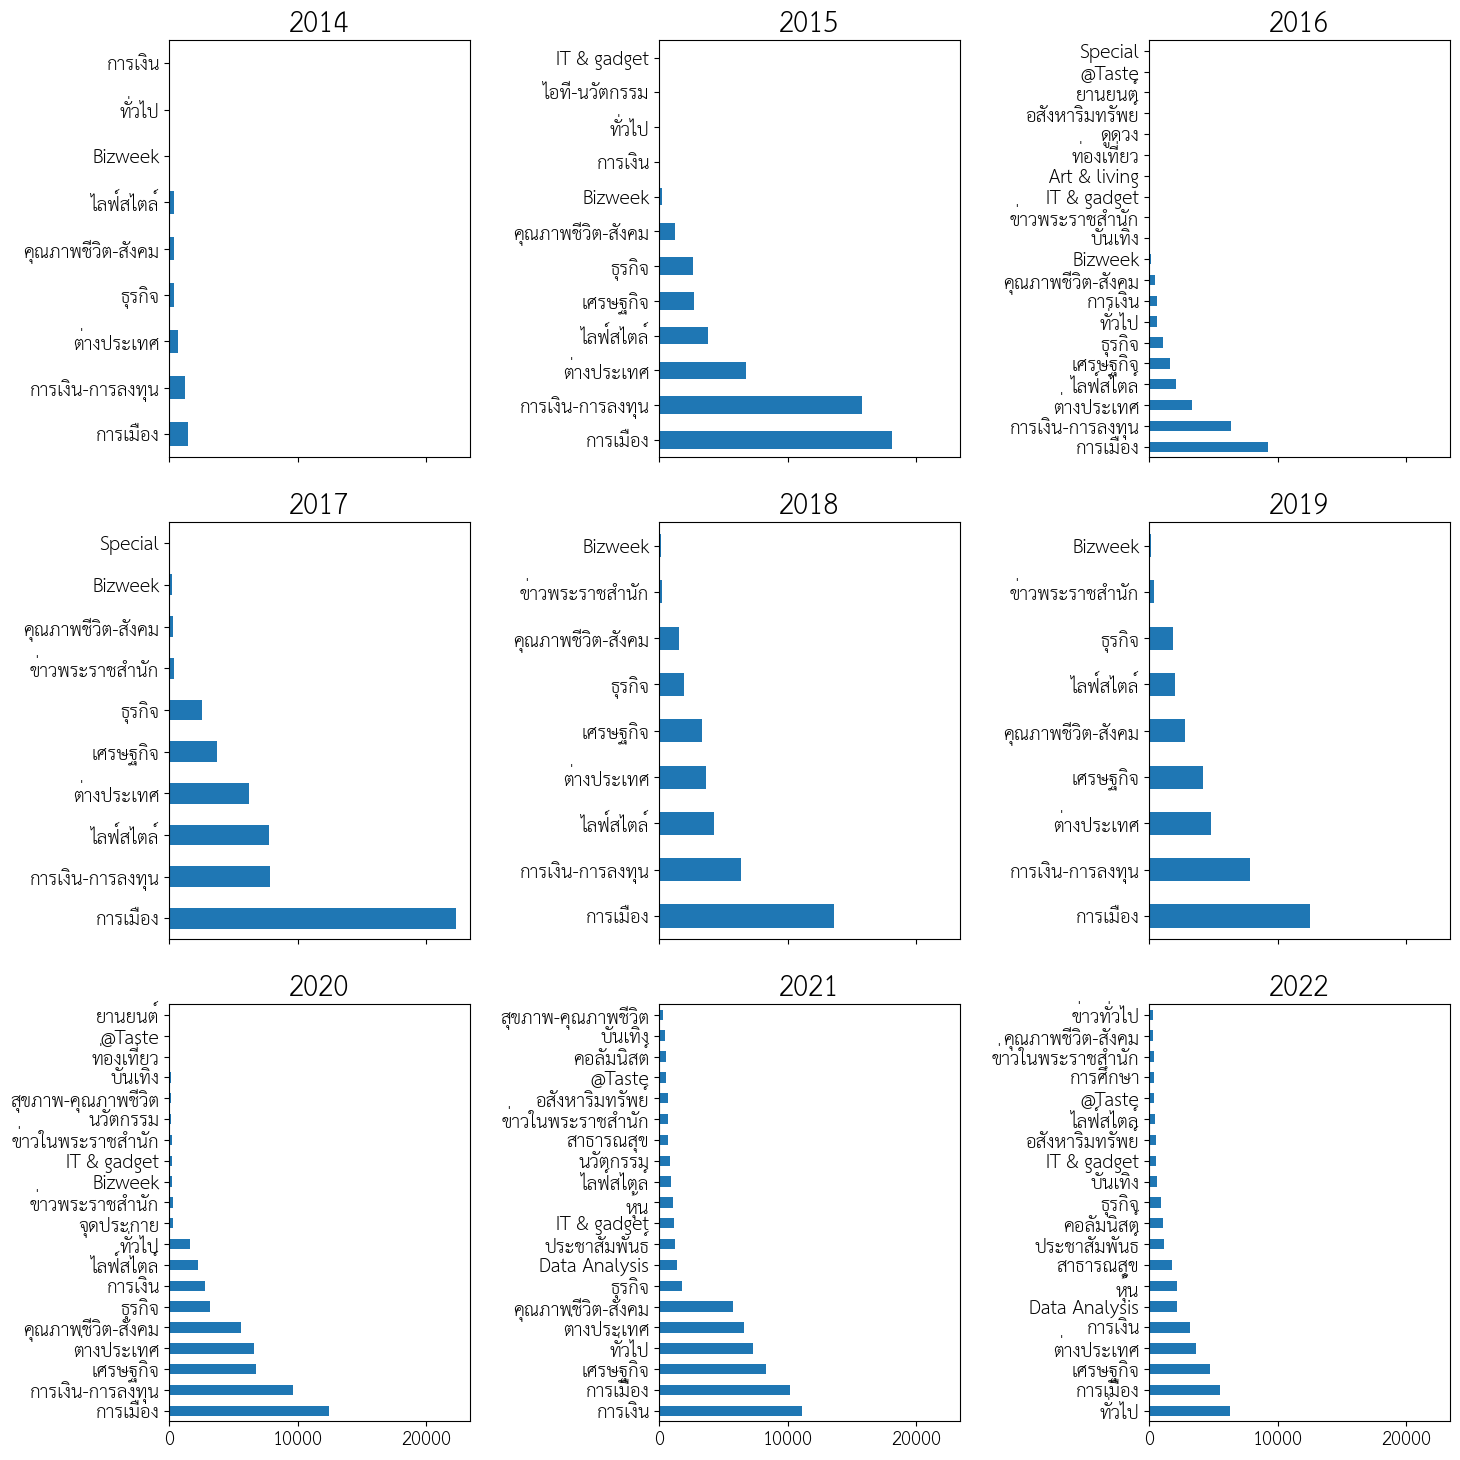

In [23]:
# Number of articles by category by year
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

fig, axs = plt.subplots(3,3, figsize=(15,15), sharex=True)
for n, year in enumerate(years):
  plt.subplot(3,3,n+1)
  plt.title(year, size=30)
  plt.tight_layout()
  bkkbiz[bkkbiz['date'].dt.year==year]['category'].value_counts().head(20).plot(kind='barh');

In [24]:
bkkbiz['category'].unique()

array(['ต่างประเทศ', 'การเงิน-การลงทุน', 'การเมือง', 'คุณภาพชีวิต-สังคม',
       'ธุรกิจ', 'ไลฟ์สไตล์', 'Bizweek', 'ทั่วไป', 'การเงิน', 'เศรษฐกิจ',
       'ไอที-นวัตกรรม', 'IT & gadget', 'ท่องเที่ยว', 'Art & living',
       'บันเทิง', 'ยานยนต์', 'อสังหาริมทรัพย์', 'ดูดวง', '@Taste',
       'ข่าวพระราชสำนัก', 'Special', 'จุดประกาย', 'Data Analysis',
       'ข่าวในพระราชสำนัก', 'นวัตกรรม', 'สุขภาพ-คุณภาพชีวิต',
       'สิ่งแวดล้อม', 'ข่าวทั่วไป', 'เศรษฐกิจ-ธุรกิจ', 'ประชาสัมพันธ์',
       'CEO Blog', 'คอลัมนิสต์', 'การศึกษา', 'ความงาม-แฟชั่น',
       'Training Course', 'Biz2U', 'หุ้น', 'Corporate Moves', 'ลอตเตอรี่',
       'สาธารณสุข', 'แรงงาน', 'เทคโนโลยี', 'คุณภาพชีวิต'], dtype=object)

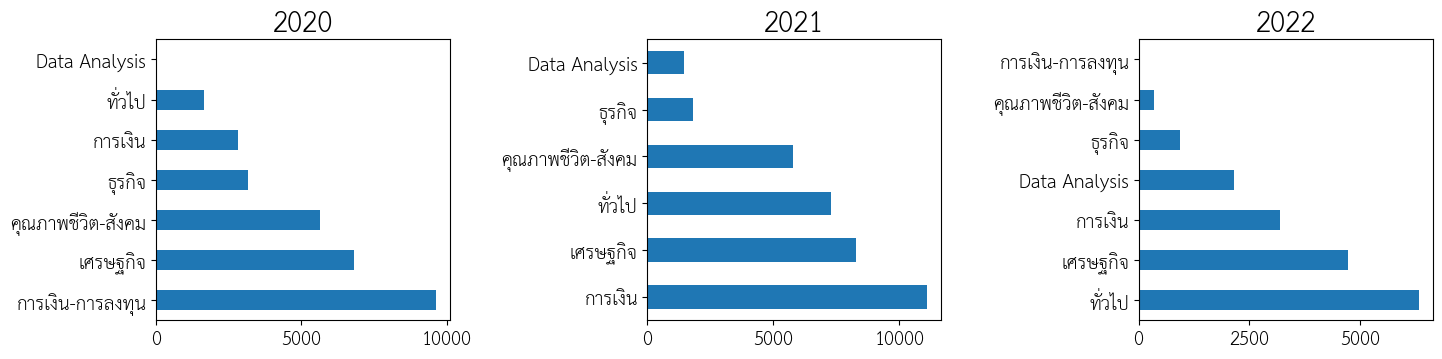

In [25]:
# Number of articles by selected 7 categories from 2020 to 2022
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2020, 2021, 2022]
category = ['การเงิน-การลงทุน', 'การเงิน', 'เศรษฐกิจ', 'คุณภาพชีวิต-สังคม', 'ธุรกิจ', 'Data Analysis', 'ทั่วไป']

fig, axs = plt.subplots(3,3, figsize=(15,4), sharex=True)
for n, year in enumerate(years):   
    plt.subplot(1,3,n+1)
    plt.title(year, size=30)
    plt.tight_layout()
    bkkbiz[(bkkbiz['date'].dt.year==year) & (bkkbiz['category'].isin(category))]['category'].value_counts().head(20).plot(kind='barh')

## 1.3.2 Matichon 

In [26]:
matichon.columns

Index(['title', 'article', 'date', 'category', 'url', 'id'], dtype='object')

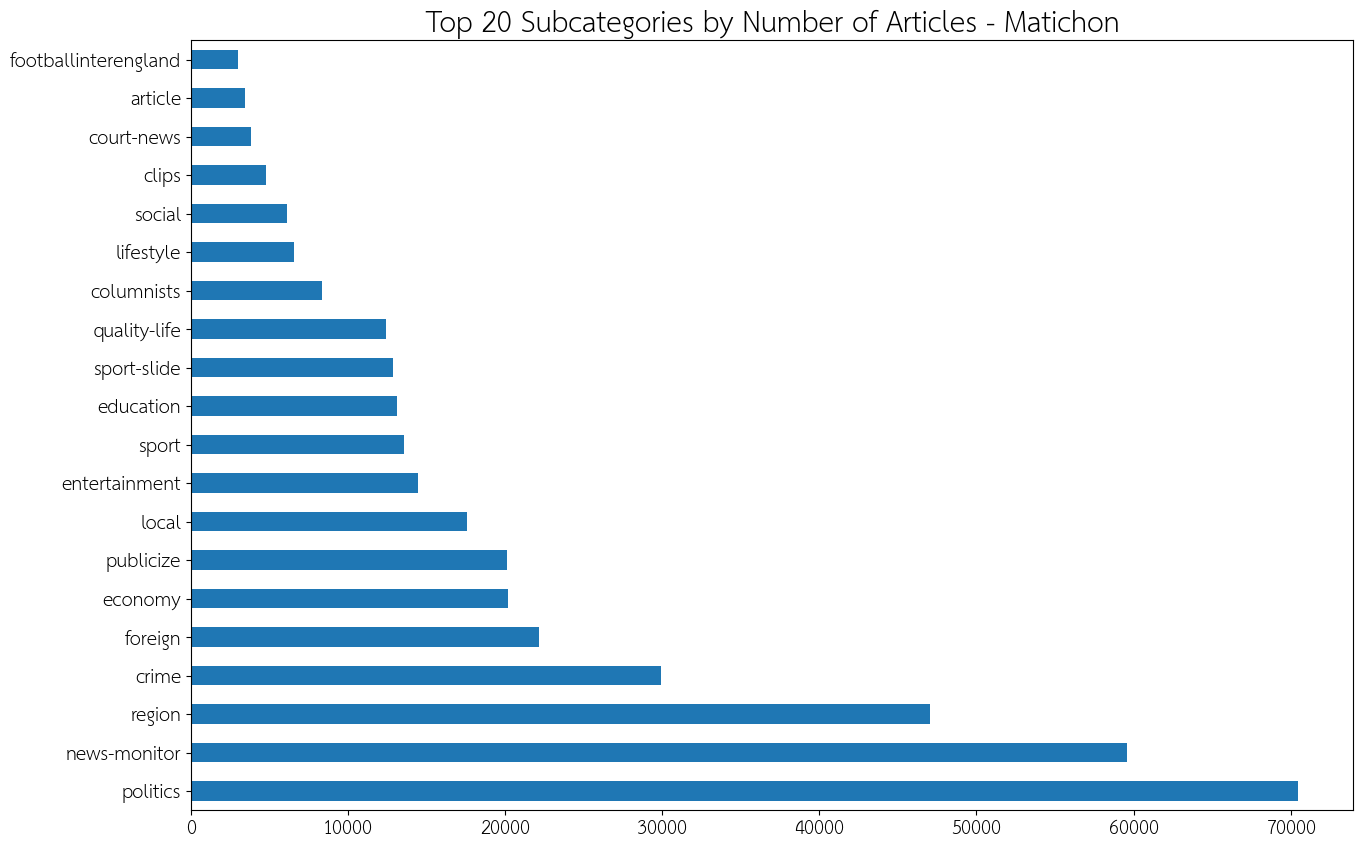

In [27]:
# Top 20 subcategories by number of articles
plt.figure(figsize=(15,10))
plt.title('Top 20 Subcategories by Number of Articles - Matichon', size=30)
matichon['category'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh');

In [28]:
# Time released
matichon['date'].dt.year.unique()

array([2015, 2016, 2018, 2019, 2017, 2014, 2020, 2021])

In [30]:
# Number of Article by Year
matichon.groupby(matichon['date'].dt.year)['title'].count()

date
2014        1
2015      199
2016    69443
2017    72300
2018    88322
2019    89246
2020    99897
2021    13493
Name: title, dtype: int64

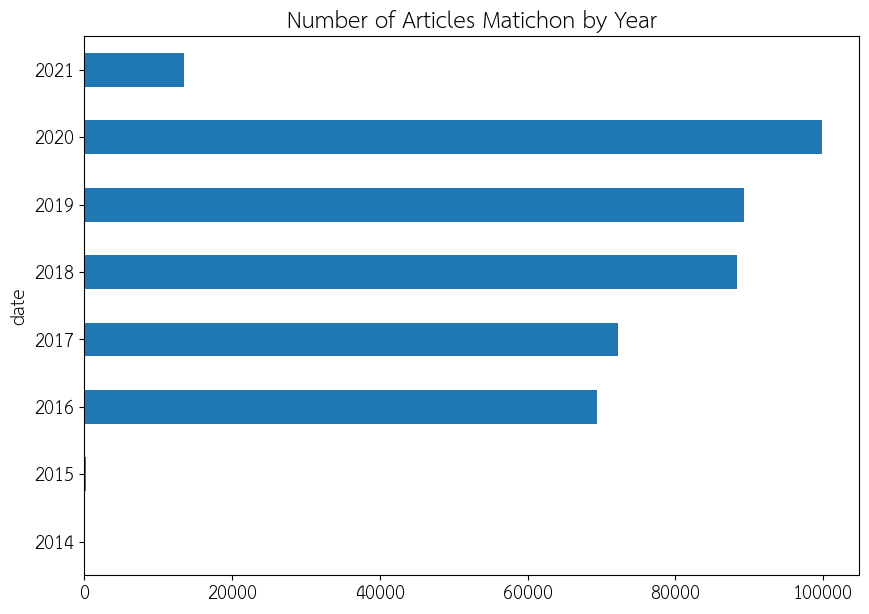

In [32]:
# Number of Article by Year
plt.figure(figsize=(10,7))
plt.title('Number of Articles Matichon by Year')
matichon.groupby(matichon['date'].dt.year)['title'].count().plot(kind='barh');

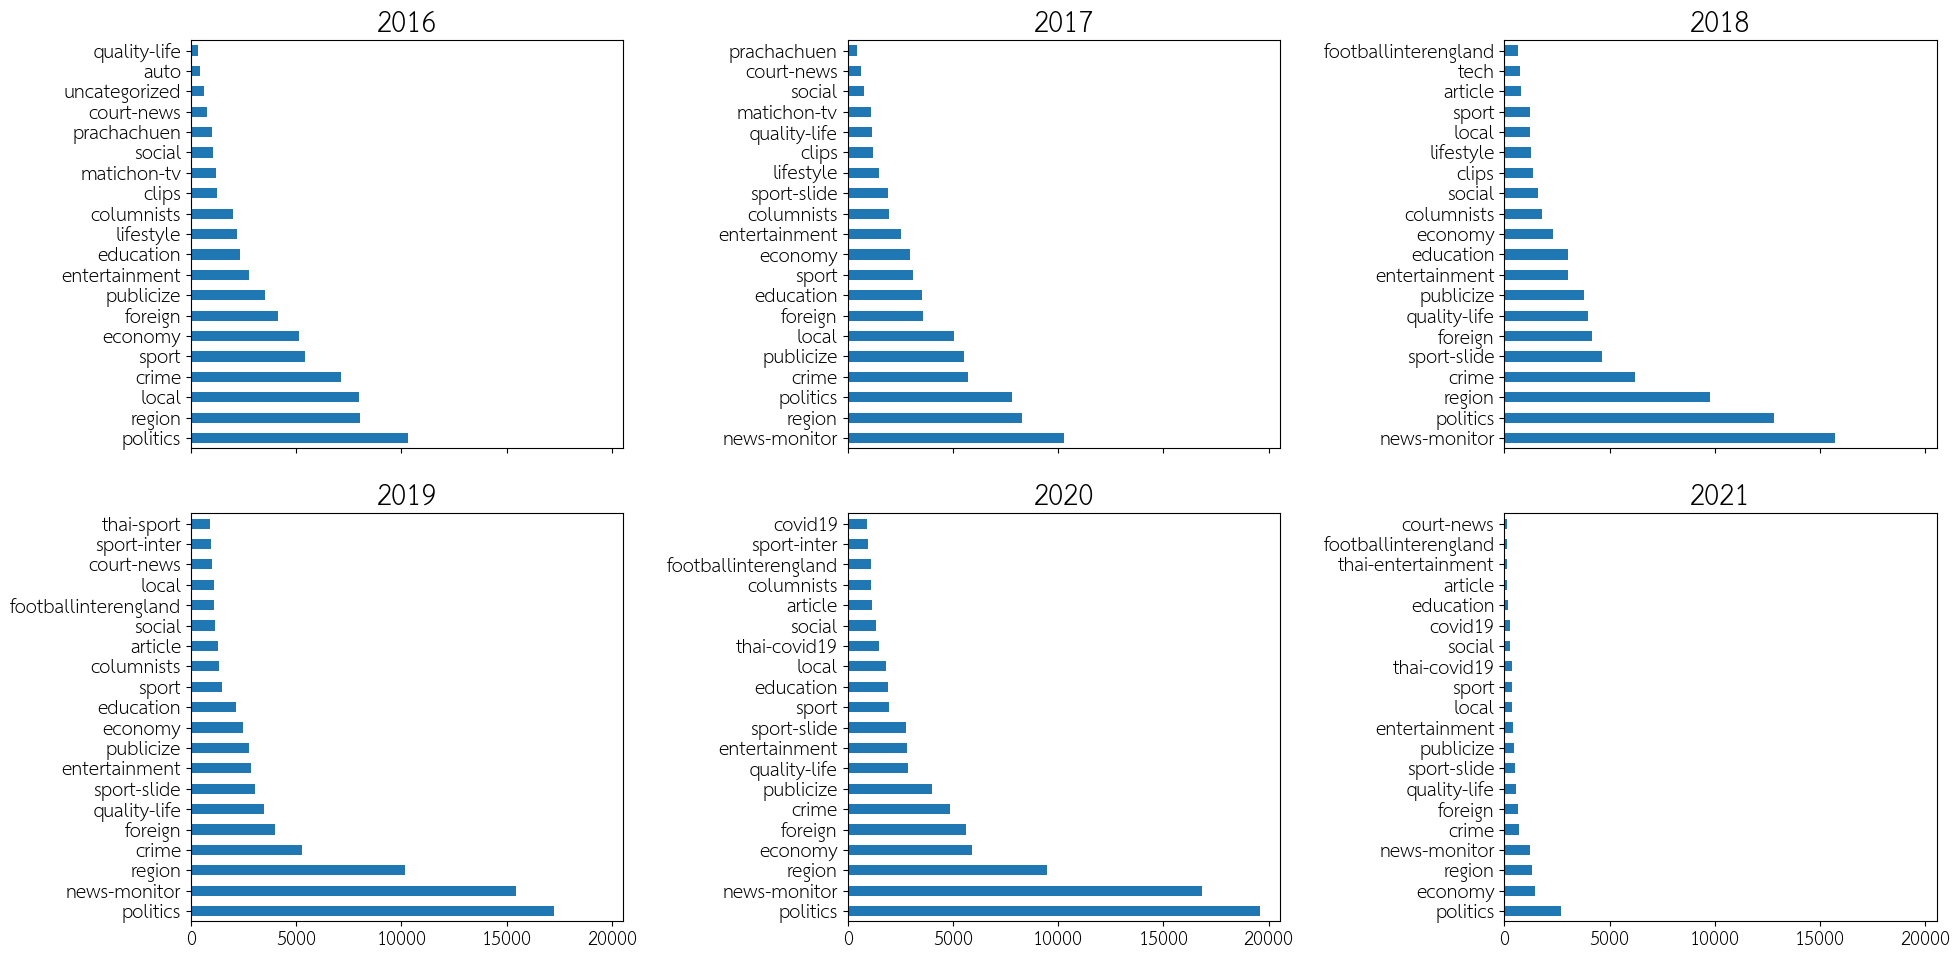

In [33]:
# Number of articles by category by year
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2016, 2017, 2018, 2019, 2020, 2021]

fig, axs = plt.subplots(2,3, figsize=(20,10), sharex=True)
for n, year in enumerate(years):
    plt.subplot(2,3,n+1)
    plt.title(year, size=30)
    plt.tight_layout()
    matichon[matichon['date'].dt.year==year]['category'].value_counts().head(20).plot(kind='barh');

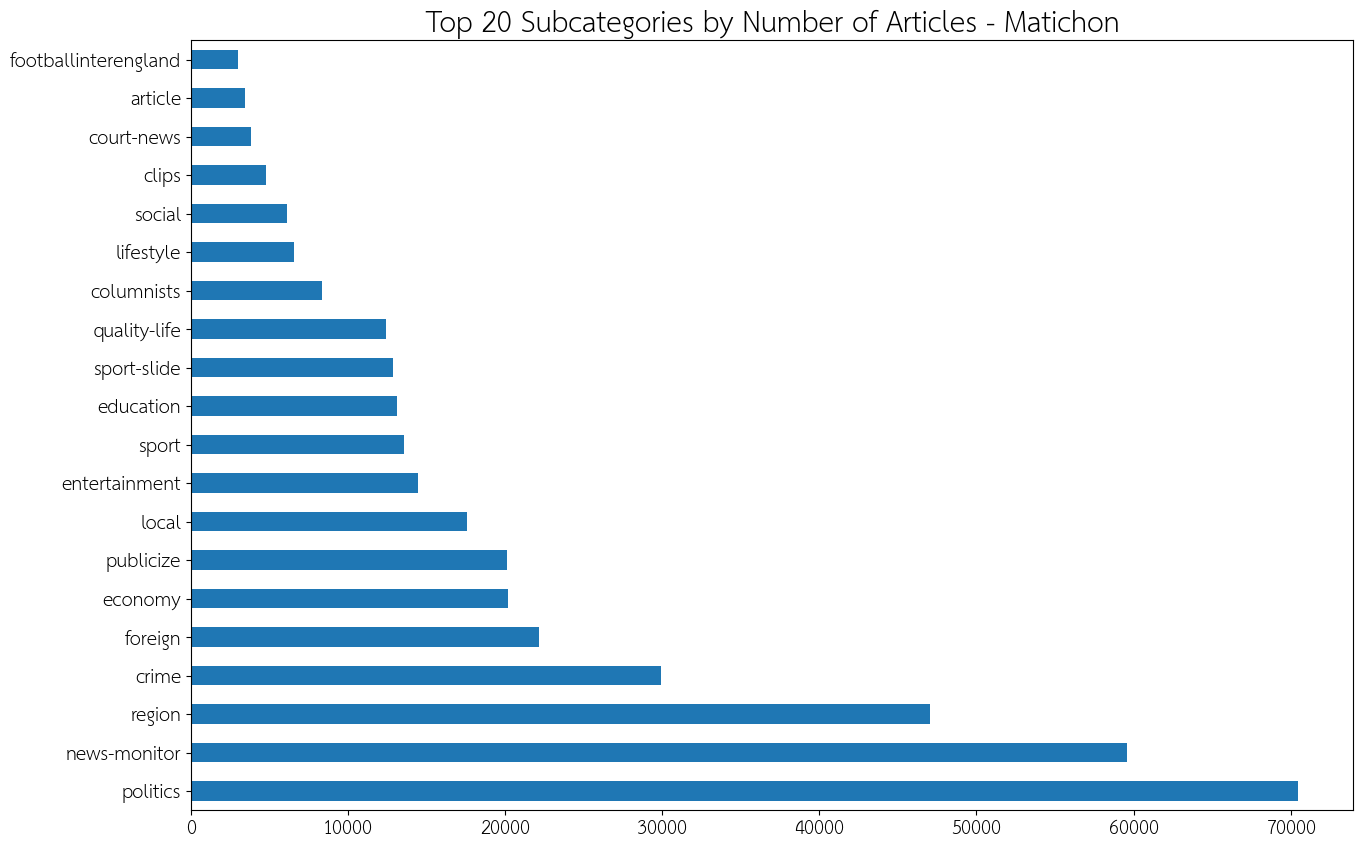

In [34]:
# Top 20 subcategories by number of articles
plt.figure(figsize=(15,10))
plt.title('Top 20 Subcategories by Number of Articles - Matichon', size=30)
matichon['category'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh');

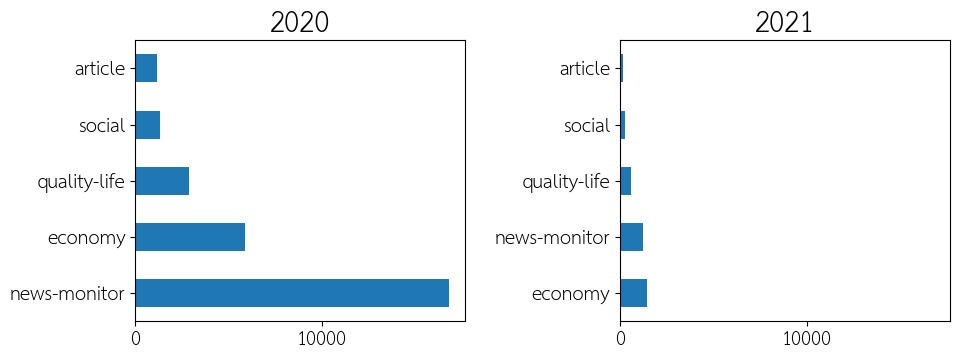

In [35]:
# Number of articles by selected 7 categories from 2020 to 2022
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2020, 2021]
category = ['economy', 'quality-life', 'social', 'article', 'news-monitor']

fig, axs = plt.subplots(1,2, figsize=(10,4), sharex=True)
for n, year in enumerate(years):   
    plt.subplot(1,2,n+1)
    plt.title(year, size=30)
    matichon[(matichon['date'].dt.year==year) & (matichon['category'].isin(category))]['category'].value_counts().head(20).plot(kind='barh')
    plt.tight_layout();

NameError: name 'b_dfs' is not defined

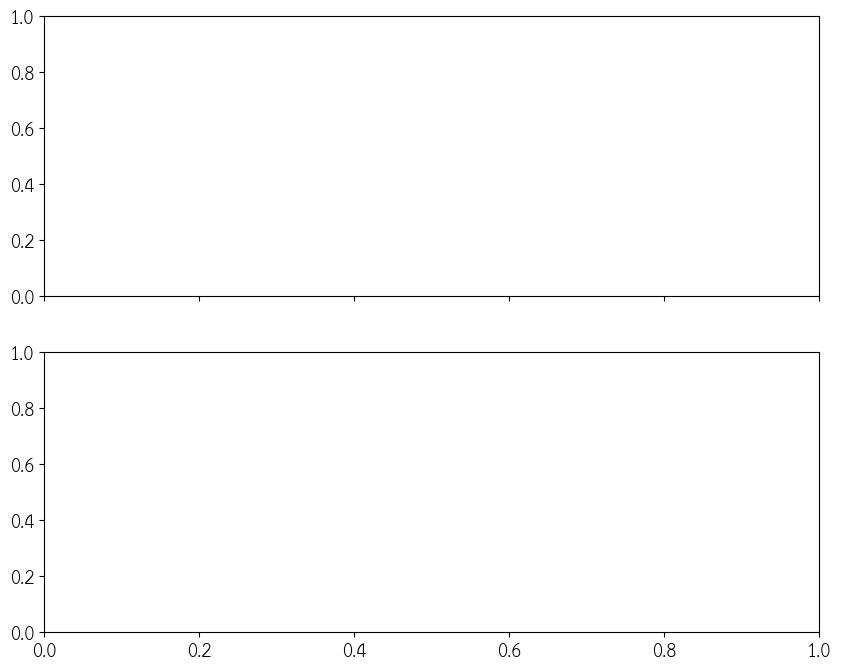

In [36]:
# Compare word count in title

# Color dictionary
colors = ['#F1948A' , '#BB8FCE', '#5DADE2', \
          '#45B39D', '#F39C12', '#D35400']

plt.subplots(2,1, figsize=(10,8), sharex=True);
for n, df in enumerate(b_dfs):
    plt.subplot(2,1,1)
    sns.kdeplot(data=df['title_count'], label=b_names[n], color=colors[n]).set_title('BkkBiz: Title Count')
    plt.legend()
    plt.tight_layout();
    
for n, df in enumerate(m_dfs):
    plt.subplot(2,1,2)
    sns.kdeplot(data=df['title_count'], label=m_names[n], color=colors[n]).set_title('Matichon: Title Count')
    plt.legend()
    plt.tight_layout();

In [ ]:
# Compare word count in article

plt.title('Article Body Word Counts', size=20)
for n, df in enumerate(dfs):
    sns.kdeplot(data=df['article_count'], label=names[n], color=colors[names[n]])
    plt.legend()
    plt.tight_layout();

In [ ]:
# Compare word count in article(article body)

# Color dictionary
colors = ['#F1948A' , '#BB8FCE', '#5DADE2', \
          '#45B39D', '#F39C12', '#D35400']

plt.subplots(2,1, figsize=(10,8), sharex=True);
for n, df in enumerate(b_dfs):
    plt.subplot(2,1,1)
    sns.kdeplot(data=df['article_count'], label=b_names[n], color=colors[n]).set_title('BkkBiz: Article Body Count')
    plt.legend()
    plt.tight_layout();
    
for n, df in enumerate(m_dfs):
    plt.subplot(2,1,2)
    sns.kdeplot(data=df['article_count'], label=m_names[n], color=colors[n]).set_title('Matichon: Article Body Count')
    plt.legend()
    plt.tight_layout();

In [ ]:
# Compare word count in article(article body): filter n_word < 2000

# Color dictionary
colors = ['#F1948A' , '#BB8FCE', '#5DADE2', \
          '#45B39D', '#F39C12', '#D35400']

plt.subplots(2,1, figsize=(10,8), sharex=True);
for n, df in enumerate(b_dfs):
    plt.subplot(2,1,1)
    sns.kdeplot(data=df[df['article_count'] < 2000]['article_count'], label=b_names[n], color=colors[n]).set_title('BkkBiz: Article Body Count')
    plt.legend()
    plt.tight_layout();
    
for n, df in enumerate(m_dfs):
    plt.subplot(2,1,2)
    sns.kdeplot(data=df[df['article_count'] < 2000]['article_count'], label=m_names[n], color=colors[n]).set_title('Matichon: Article Body Count')
    plt.legend()
    plt.tight_layout();

In [38]:
bkkbiz.head()

,ID,date,category,title,description,article,url
0,620001,2014-11-27 08:01:00,ต่างประเทศ,น้ำมันดิบปิดร่วง-คาดโอเปคไม่ลดกำลังผลิต,น้ำมันดิบปิดร่วงแตะระดับต่ำสุดในรอบ 4 ปี-คาดโอ...,สัญญาน้ำมันดิบตลาดล่วงหน้าสหรัฐ ปิดตลาดปรับตัว...,https://www.bangkokbiznews.com/news/detail/620001
1,620002,2014-11-27 08:20:00,ต่างประเทศ,ทองคำปิดร่วงหลังสหรัฐเผยข้อมูลเศรษฐกิจ,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,https://www.bangkokbiznews.com/news/detail/620002
2,620009,2014-11-27 09:34:00,การเงิน-การลงทุน,"ทองแท่งขายออก18,600บ.ไม่เปลี่ยนแปลง","ราคาทองคำวันนี้ทองแท่งขายออกบาทละ 18,600 บาท ท...",สมาคมค้าทองคำรายงานราคาทอง 96.5% ประจำวันที่ 2...,https://www.bangkokbiznews.com/news/detail/620009
3,620010,2014-11-27 09:36:00,การเงิน-การลงทุน,เงินบาทเปิด32.75/77คาดแกว่งแคบ,ค่าเงินบาทเปิดที่ 32.75/77 บาท/ดอลลาร์ คาดแกว่...,นักบริหารเงินจากธนาคารพาณิชย์ เปิดเผยว่า เงินบ...,https://www.bangkokbiznews.com/news/detail/620010
4,620011,2014-11-27 09:48:00,การเงิน-การลงทุน,คาดหุ้นเช้าแกว่งไซด์เวย์,โบรกฯ คาดหุ้นเช้านี้แกว่งไซด์เวย์ช่วงไร้ปัจจัย...,นายอภิชาติ ผู้บรรเจิดกุล ผู้อำนวยการสายงานวิเค...,https://www.bangkokbiznews.com/news/detail/620011


In [44]:
# Filter articles that contains the word 'ดิจิทัล' (digital)
bkkbiz_digital = bkkbiz[bkkbiz['article'].str.contains(pat='ดิจิทัล')].reset_index(drop=True)
bkkbiz_digital

,ID,date,category,title,description,article,url
0,620015,2014-11-27 10:08:00,การเงิน-การลงทุน,เนชั่นจ่อปรับค่าโฆษณา20%,"""เนชั่น มัลติมีเดีย กรุ๊ป""หวังรายได้ปีหน้าแตะ3...",นางสาวดวงกมล โชตะนา กรรมการผู้อำนวยการ บริษัท ...,https://www.bangkokbiznews.com/news/detail/620015
1,620023,2014-11-27 10:26:00,การเมือง,ทุ่ม80ล้านเปิดเวที77จว.,สปช.ลุยฟังความเห็นปฏิรูป-คิกออฟ1ธ.ค. รวบ2ผู้ต้...,สปช.ทุ่มงบ 80 ล้าน เปิด 1.3 พันเวทีปฏิรูป รับฟ...,https://www.bangkokbiznews.com/news/detail/620023
2,620025,2014-11-27 10:35:00,ธุรกิจ,NOW26ปักหลักสยามสแควร์ เปิดสตูดิโอใหม่พันตรม.-...,เปิดแผนปี 2558 ดิจิทัลทีวี NOW26 เตรียมเปิดสตู...,เพิ่มช่องทางเข้าถึงคนรุ่นใหม่ สร้างประสบการณ์ร...,https://www.bangkokbiznews.com/news/detail/620025
3,620054,2014-11-27 11:08:00,การเงิน-การลงทุน,NBC - ซื้อ,เตรียมปรับเพิ่มค่าโฆษณาช่อง Nation TV ขึ้น 30-50%,ปรับเพิ่มมูลค่าเหมาะสมเป็น 6 บาท เราปรับเพิ่มม...,https://www.bangkokbiznews.com/news/detail/620054
4,620065,2014-11-27 11:37:00,ธุรกิจ,'ซิคเว่'เสนอแผน'ดิจิทัลอีโคโนมี',"""ซิคเว่"" เล็งผนึก ""เอไอเอส ทรู"" พร้อมควง ""ทีโอ...","หวังสานฝันนโยบายรัฐสัมฤทธิผล รอนัดวันเข้าพบ ""ห...",https://www.bangkokbiznews.com/news/detail/620065
...,...,...,...,...,...,...,...
16459,1019855,2022-08-09 09:48:00,หุ้น,หุ้น SFT กำไรไตรมาส 2 เพิ่ม 38% เร่งขยายฐานลู...,หุ้น SFT ประกาศการดำเนินงานไตรมาส 2/2565 ทำกำไ...,นายซุง ชง ทอย ผู้ก่อตั้ง และประธานเจ้าหน้าที่บ...,https://www.bangkokbiznews.com/news/detail/101...
16460,1019905,2022-08-09 12:37:00,การเงิน,SCB Abacus จับมือ Robinhood ช่วยไรเดอร์เว้นระย...,SCB Abacus ร่วมกับ Robinhood ฟู้ดดิลิเวอรีสัญช...,นายอัญญรัตน์ บุญนิธิวรกุล Chief Commercial Off...,https://www.bangkokbiznews.com/news/detail/101...
16461,1019942,2022-08-09 15:16:00,หุ้น,SABUY เผยงบไตรมาส 2/2565 กวาดกำไร 356 ล้านบาท ...,SABUY เผยงบไตรมาส 2/2565 กวาดกำไร 356 ล้านบาท ...,นายชูเกียรติ รุจนพรพจี ประธานเจ้าหน้าที่บริหาร...,https://www.bangkokbiznews.com/news/detail/101...
16462,1019951,2022-08-09 18:00:00,การเงิน,สำนักสลาก คาดคนไทยได้เล่นผลิตภัณฑ์ใหม่กลางปีหน้า,สำนักงานสลากฯ เตรียมชงบอร์ดเดือนก.ย.นี้ เพื่อพ...,นายธนวรรธน์ พลวิชัย กรรมการและโฆษกคณะกรรมการสล...,https://www.bangkokbiznews.com/news/detail/101...


In [46]:
# Filter articles that contains the word 'ดิจิทัล' (digital)
matichon_digital = matichon[matichon['article'].str.contains(pat='ดิจิทัล')].reset_index(drop=True)
matichon_digital

,title,article,date,category,url,id
0,"แห่ชมฝนดาวตก ""เจมินิดส์""คึกคัก ""ดอยอินทนนท์"" ช...",วันที่ 15 ธันวาคม นายศรันย์ โปษยะจินดา รองผู้อ...,2015-12-15 02:36:22+00:00,region,https://www.matichon.co.th/region/news_622,622
1,สมาชิกรุมจวกกม.คลื่นความถี่! 'วิทยา' ซัดสปท.ไม...,ถก ร่างแก้ไข พ.ร.บ.องค์กรจัดสรรคลื่นความถี่ ทำ...,2016-01-18 23:48:28+00:00,politics,https://www.matichon.co.th/politics/news_5384,5384
2,โครงการ 3 ประสานความร่วมมือ กสทช. กสท และ CABSAT,โครงการ 3 ประสานความร่วมมือ กสทช. กสท และ CABS...,2016-01-20 09:08:59+00:00,publicize,https://www.matichon.co.th/publicize/news_6608,6608
3,"เอไอเอส จัดเต็ม มหกรรม ""AIS 4G ADVANCED NEW WO...","เอไอเอสขอเชิญลูกค้าและประชาชน ร่วมงานมหกรรม ""A...",2016-01-24 09:08:54+00:00,publicize,https://www.matichon.co.th/publicize/news_11306,11306
4,"CAT เปิดศูนย์นวัตกรรม ""IOT City Innovation Ce...",บมจ. กสท โทรคมนาคม (CAT) วางโครงข่ายระบบไอทีค...,2016-01-24 12:46:00+00:00,publicize,https://www.matichon.co.th/publicize/news_11463,11463
...,...,...,...,...,...,...
10428,'การบินไทย' แจงแผนปรับโครงสร้างองค์กร โละผู้บร...,นายชาญศิลป์ ตรีนุชกร รักษาการแทนกรรมการผู้อำนว...,2021-02-19 14:55:57+00:00,economy,https://www.matichon.co.th/economy/news_2586569,2586569
10429,"""นักวิชาการ"" เปรียบภาพ ตา-ยาย ป้อนข้าวรอลงทะเบ...",เมื่อวันที่ 19 ก.พ.64 รศ.ดร.เสรี พงศ์พิศ นักวิ...,2021-02-19 15:33:48+00:00,economy,https://www.matichon.co.th/economy/news_2586692,2586692
10430,LINE เปิด Clubhouse จัดห้องให้โค้ชช่วยติดเขี้ย...,นางสาวสกุลรัตน์ ตันยงศิริ ผู้อำนวยการธุรกิจ SM...,2021-02-19 15:30:18+00:00,news-monitor,https://www.matichon.co.th/news-monitor/news_2...,2586693
10431,'ถิรไทย' เอ็มโอยูทางออนไลน์กับเยอรมนี-ออสเตรีย...,"""ด้วยทักษะและประสบการณ์ที่ยาวนานในธุรกิจหม้อแป...",2021-02-19 16:16:18+00:00,economy,https://www.matichon.co.th/economy/news_2586812,2586812


## 1.4 Pre-Processing
---



#### Pre-processing workflows
1. create new DataFrame 
2. count words: 'title', 'description', 'article' 
3. list: tokenize + remove stop words + RegEx 
4. unlist: tokenize + remove stop words + RegEx

- Create new DataFrame based on articles from the following categories: 

Reasons
- total amount of articles
- constant number of article across years
| category | DataFrame Name |
| ---| ---|
| การเงิน-การลงทุน + การเงิน | finance |
| เศรษฐกิจ| econ |
| คุณภาพชีวิต-สังคม | social |
| ธุรกิจ | business |
| Data analysis | data |
| ทั่วไป | general | 

In [47]:
# Create function that tokenize, remove stopwords and perform RegularExpression
#def tokenize(txt):
  
#    ''' 
#    Description:
#        A function that returns tokenized words with stop words and other regular expressions 
#        that do not match English and Thai alphabets removed

#    Parameters:
#        txt = text string

#    Return:
#        word tokens as list
#    '''

#    stopwords = thai_stopwords()
#    tokens = word_tokenize(txt, keep_whitespace = False)
#    tokens = [token for token in tokens if token not in stopwords]
#    tokens = [token for token in tokens if re.match(r'[A-Za-zก-๙0-9]+', token)]
#    return tokens

In [53]:
# Create function that tokenize, remove stopwords and perform RegularExpression
def tokenize(txt):
  
    ''' 
    Description:
        A function that returns tokenized words with stop words and other regular expressions 
        that do not match English and Thai alphabets removed

    Parameters:
        txt = text string

    Return:
        word tokens as list
    '''

    stopwords = thai_stopwords()
    tokens = word_tokenize(txt, keep_whitespace = False)
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [token for token in tokens if re.match(r'[A-Za-zก-\uDe5c]+', token)]
    return tokens

In [54]:
# Write a function for generating new DataFrame 

# List of columns
cols = ['title', 'description', 'article']

def new_df(data=None):

    '''
    Description:
        A function that create a new DataFrame from existing bkkbiz corpus 
        The following new features will be created as a result of the function:
          1. word count
          2. tokenized words list
          3. tokenized words outside of a list
    Parameters:
        Name of the new DataFrame
    Returns:
        New DataFrame
    '''

    # 1. Create new DataFrame
    new_df = data.reset_index(drop=True)

    # 2. Create word count columns
    for col in tqdm(cols):
        new_df[col+'_count'] = new_df[col].\
                                apply(lambda x: len(word_tokenize(x ,keep_whitespace=False)))

        # 3. Tokenize, remove stop words, perform regular expression > ready for topic modeling
        new_df[col+'_tokenize'] = new_df[col].apply(tokenize)

        # 4. Take the tokens out of the list > ready to be vectorized
        #new_df[col+'_tokenize_unlist'] = new_df[col+'_tokenize_list'].apply(lambda x:' '.join(x))

    return new_df

In [20]:
bkkbiz['category'].unique()

array(['ต่างประเทศ', 'การเงิน-การลงทุน', 'การเมือง', 'คุณภาพชีวิต-สังคม',
       'ธุรกิจ', 'ไลฟ์สไตล์', 'Bizweek', 'ทั่วไป', 'การเงิน', 'เศรษฐกิจ',
       'ไอที-นวัตกรรม', 'IT & gadget', 'ท่องเที่ยว', 'Art & living',
       'บันเทิง', 'ยานยนต์', 'อสังหาริมทรัพย์', 'ดูดวง', '@Taste',
       'ข่าวพระราชสำนัก', 'Special', 'จุดประกาย', 'Data Analysis',
       'ข่าวในพระราชสำนัก', 'นวัตกรรม', 'สุขภาพ-คุณภาพชีวิต',
       'สิ่งแวดล้อม', 'ข่าวทั่วไป', 'เศรษฐกิจ-ธุรกิจ', 'ประชาสัมพันธ์',
       'CEO Blog', 'คอลัมนิสต์', 'การศึกษา', 'ความงาม-แฟชั่น',
       'Training Course', 'Biz2U', 'หุ้น', 'Corporate Moves', 'ลอตเตอรี่',
       'สาธารณสุข', 'แรงงาน', 'เทคโนโลยี', 'คุณภาพชีวิต'], dtype=object)

In [47]:
# Create a list of years & category
# years = [2020, 2021, 2022]
years = [2020]
categories = ['การเงิน-การลงทุน', 'การเงิน', 'เศรษฐกิจ', 'คุณภาพชีวิต-สังคม', 'ธุรกิจ', 'Data Analysis', 'ทั่วไป']
categories_matichon = ['economy', 'quality-life', 'social', 'article', 'news-monitor']

In [44]:
data = bkkbiz[(bkkbiz['date'].dt.year.isin(years)) & ((bkkbiz['category']=='การเงิน-การลงทุน') | (bkkbiz['category']=='การเงิน'))]
data.groupby(bkkbiz['date'].dt.year)['title'].count()
#investment = new_df(data=bkkbiz)
#bkkbiz.head(1)

date
2020    12442
Name: title, dtype: int64

In [45]:
#  Process Data from BkkBiz
for category in categories:
    data = bkkbiz[(bkkbiz['date'].dt.year.isin(years)) & ((bkkbiz['category']==category))]
    df_name = category
    df_name = new_df(data=data)
    df_name.to_json(f'../datasets/{category}_processed.json')
    print(f'Finish processing and saving "{category}" yayyy!')

100%|█████████████████████████████████████████████| 3/3 [01:21<00:00, 27.01s/it]


Finish processing and saving "การเงิน-การลงทุน" yayyy!


100%|█████████████████████████████████████████████| 3/3 [00:14<00:00,  4.80s/it]


Finish processing and saving "การเงิน" yayyy!


100%|█████████████████████████████████████████████| 3/3 [00:53<00:00, 17.99s/it]


Finish processing and saving "เศรษฐกิจ" yayyy!


100%|█████████████████████████████████████████████| 3/3 [01:01<00:00, 20.58s/it]


Finish processing and saving "คุณภาพชีวิต-สังคม" yayyy!


100%|█████████████████████████████████████████████| 3/3 [01:16<00:00, 25.60s/it]


Finish processing and saving "ธุรกิจ" yayyy!


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 22.19it/s]


Finish processing and saving "Data Analysis" yayyy!


100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.15s/it]

Finish processing and saving "ทั่วไป" yayyy!


In [55]:
# Process Data from BkkBiz that contains the word 'ดิจิทัล'(digital)
bkkbiz_digital_processed = new_df(bkkbiz_digital)
bkkbiz_digital_processed.to_json('../datasets/bkkbiz_digital_processed.json')

100%|███████████████████████████████████████████████████| 3/3 [04:15<00:00, 85.28s/it]


In [56]:
#  Process Data from Matichon
cols = ['title', 'article']

for category in categories_matichon:
    data = matichon[(matichon['date'].dt.year.isin(years)) & ((matichon['category']==category))]
    df_name = category
    df_name = new_df(data=data)
    df_name.to_json(f'../datasets/{category}_processed.json')
    print(f'Finish processing and saving "{category}" yayyy!')#  Pre-Process Data from Matichon

NameError: name 'categories_matichon' is not defined

In [57]:
# Process Data from BkkBiz that contains the word 'ดิจิทัล'(digital)
cols = ['title', 'article']

matichon_digital = new_df(data=matichon_digital)
matichon_digital.to_json(f'../datasets/matichon_digital_processed.json')

100%|███████████████████████████████████████████████████| 2/2 [02:25<00:00, 72.53s/it]


In [24]:
# COLAB
# Download 
# for key in df_dict:
#  files.download(f'{key}.csv')
#  print(f'Finish downloading "{key}" DataFrame')

## 1.5 Modeling for Datasets Selection

In [67]:
# Bangkok Business
# ----------------------------- #
df_1 = pd.read_json('../datasets/การเงิน_processed.json')
df_2 = pd.read_json('../datasets/การเงิน-การลงทุน_processed.json')

b_finance = pd.concat([df_1, df_2], ignore_index=True)
b_economic = pd.read_json('../datasets/เศรษฐกิจ_processed.json')
b_social = pd.read_json('../datasets/คุณภาพชีวิต-สังคม_processed.json')
b_business = pd.read_json('../datasets/ธุรกิจ_processed.json')
b_data = pd.read_json('../datasets/Data Analysis_processed.json')
b_general = pd.read_json('../datasets/ทั่วไป_processed.json')

In [65]:
# Matichon
# ----------------------------- #
m_economic = pd.read_json('../datasets/economy_processed.json')
m_social = pd.read_json('../datasets/quality-life_processed.json')
m_life = pd.read_json('../datasets/social_processed.json')
m_article = pd.read_json('../datasets/article_processed.json')
m_news = pd.read_json('../datasets/news-monitor_processed.json')



# Create new DF by categories
#variables = ['economic', 'social', 'business', 'data', 'general']
#categories = ['เศรษฐกิจ', 'คุณภาพชีวิต-สังคม', 'ธุรกิจ', 'Data Analysis', 'ทั่วไป']
#for i in range(5):
#    df_name = variables[i]
#    print(df_name)
#    df_name = pd.read_json(f'../datasets/{categories[i]}_processed.json')
#    print(f'../datasets/{categories[i]}_processed.json')'''

In [69]:
b_names = ['b_finance', 'b_economic', 'b_social', 'b_business', 'b_general']
b_dfs = [b_finance, b_economic, b_social, b_business, b_data, b_general]

for n, df in enumerate(b_dfs):
    print(f'Shape of {b_names[n]}: {df.shape}')

Shape of b_finance: (12442, 13)
Shape of b_economic: (6801, 13)
Shape of b_social: (5636, 13)
Shape of b_business: (3164, 13)
Shape of b_data: (34, 13)
Shape of b_general: (1640, 13)


In [77]:
m_names = ['m_economic', 'm_social', 'm_life', 'm_article', 'm_news']
m_dfs = [m_economic, m_social, m_life, m_article, m_news]

for n, df in enumerate(m_dfs):
    print(f'Shape of {m_names[n]}: {df.shape}')

Shape of m_economic: (5884, 10)
Shape of m_social: (2887, 10)
Shape of m_life: (1348, 10)
Shape of m_article: (1173, 10)
Shape of m_news: (16824, 10)


In [118]:
#for df in b_dfs:
#    print(df.isnull().sum())

In [117]:
#for df in m_dfs:
#    print(df.isnull().sum())

In [29]:
# Function for creating new corpus
#def lda_corpus(data=None):
#    dictionary = Dictionary(data)
#    corpus = [dictionary.doc2bow(txt) for txt in data]
#    return dictionary, corpus

In [83]:
# Function for modeling with LDA
def lda_model(data=None, num_topics=None): #, topicid=None
    
    dictionary = Dictionary(data)
    corpus = [dictionary.doc2bow(txt) for txt in data]
    
    model = LdaModel(corpus=corpus, num_topics=num_topics)
    #topic = pd.DataFrame(model.get_topic_terms(topicid=1, topn=20)).rename(columns={0:'index', 1:'probability'})
    for i in range(num_topics):
        top_n = [dictionary[index] for index, prob in model.get_topic_terms(topicid=i, topn=20)]
        print(f'Topic {i+1}')
        print(top_n)
        print('-'*60)
    return model


In [85]:
# LDA Model - bkkbiz
for i in range(len(b_names)):
    print(f'{b_names[i].upper()}')
    print('*'*60)
    
    model = lda_model(data=b_dfs[i]['article_tokenize'], 
            num_topics=10)
    model
    
    print(' ')
    print(' ')

B_FINANCE
************************************************************
Topic 1
['บริษัท', 'บาท', 'ปี', 'ล้าน', 'ธุรกิจ', 'ไทย', '2563', 'ประตู', 'ลูกค้า', 'ธนาคาร', 'ประเทศ', 'โซเชียล', '1', 'จำกัด', 'ใช้ประโยชน์', 'ราคา', 'วิศวกรรม', 'วันที่', 'จำนวน', 'จ่าย']
------------------------------------------------------------
Topic 2
['20', 'Futures', 'สัญญา', 'ราคา', 'การซื้อขาย', 'ปริมาณ', 'ผู้ลงทุน', '50', 'Gold', 'ระดับ', 'SET', 'สำหรับ', '3', 'ประเภท', 'yoy', 'Bt', 'm', 'บาท', 'จุด', 'Index']
------------------------------------------------------------
Topic 3
['ไทย', 'เศรษฐกิจ', 'ตลาด', 'หุ้น', 'ระดับ', 'ดัชนี', 'เดือน', 'ดอลลาร์', 'ปี', 'ประเทศ', '19', 'โควิด', 'บาท', 'คาด', 'ตลาดหุ้น', 'สหรัฐ', 'นักลงทุน', 'มาตรการ', 'ปรับตัว', '2']
------------------------------------------------------------
Topic 4
['ปี', 'กำไร', 'Q', 'ล้าน', 'บาท', 'คาด', 'ลดลง', '63', '2', 'เพิ่มขึ้น', 'รายได้', 'YoY', '1', 'ธุรกิจ', 'บริษัท', '2563', 'ประมาณการ', 'ราคา', '3', 'อัตรา']
--------------------------

In [86]:
# LDA Model - Matichon
for i in range(len(m_names)):
    print(f'{m_names[i].upper()}')
    print('*'*60)
    
    model = lda_model(data=m_dfs[i]['article_tokenize'], 
            num_topics=10)
    model
    
    print(' ')
    print(' ')

M_ECONOMIC
************************************************************
Topic 1
['ไฟฟ้า', 'ระบบ', 'ปี', 'โครงการ', 'รถยนต์', 'พลังงาน', 'น้ำ', 'ล้าน', 'อี', 'ไทย', 'พื้นที่', '2', 'รถ', 'ประเทศ', 'เทคโนโลยี', 'สำหรับ', 'บาท', 'ข้อมูล', 'สถานการณ์', 'บริษัท']
------------------------------------------------------------
Topic 2
['บาท', 'สหรัฐ', 'ระดับ', 'ปี', 'ราคา', 'เศรษฐกิจ', 'ล้าน', 'ตลาด', 'ไทย', 'ทองคำ', 'ดอลลาร์', '2563', 'ขาย', 'คาด', 'ลดลง', 'นโยบาย', 'ปรับตัว', 'เดือน', 'จุด', 'ดัชนี']
------------------------------------------------------------
Topic 3
['ไทย', 'ประเทศ', 'เรื่อง', 'วันที่', 'โครงการ', 'คน', 'บริษัท', 'ทำ', 'เข้ามา', 'ธุรกิจ', 'การท่องเที่ยว', '2', 'กิจการ', 'พื้นที่', '3', '1', '2563', 'ปี', 'กล่าวว่า', 'บิน']
------------------------------------------------------------
Topic 4
['บาท', 'ล้าน', 'ปี', '2', 'ไทย', '5', '1', 'โครงการ', 'ธนาคาร', 'ลูกค้า', '2563', 'วันที่', 'เดือน', 'สำหรับ', '3', 'สินเชื่อ', 'ตลาด', 'รายได้', 'จำนวน', 'สถานการณ์']
-----------------

In [35]:
import warnings
warnings.filterwarnings('ignore') 
#warnings.filterwarnings('ignore', category=FutureWarning) 

In [36]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import numpy as np

In [39]:
import warnings as wa
wa.warn_explicit = wa.warn = lambda *_, **__: None

In [89]:
import logging

logging.captureWarnings(capture=True)

# Get logger for warnings
logger = logging.getLogger("py.warnings")

# StreamHandler outputs on sys.stderr by default
handler = logging.StreamHandler()
logger.addHandler(handler)

# Set rule to ignore warnings
logger.addFilter(lambda record: "DeprecationWarning" not in record.getMessage())

In [90]:
# Visualization
def lda_vis(data=None, num_topics=20):
    dictionary = Dictionary(data)
    corpus = [dictionary.doc2bow(txt) for txt in data]
    model = LdaModel(corpus=corpus, num_topics=num_topics)
    pyLDAvis.enable_notebook()
    viz = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    return viz

In [92]:
#lda_vis(data=b_economic['article_tokenize'])

In [ ]:
lda_vis(data=social['article_tokenize'])

In [ ]:
lda_vis(data=economic['article_tokenize'])

In [ ]:
lda_vis(data=business['article_tokenize'])

In [ ]:
lda_vis(data=general['article_tokenize'])

In [ ]:
# Create new DataFrame
# for key in df_dict:
#  df = cat_df(key)
#  df.to_csv(f'{key}.csv')
#  print(f'Finish creating "{key}" DataFrame')